## installing dependencies

In [ ]:
!pip install opencv-python

In [ ]:
!pip install pillow

## importing libraries

In [88]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import gym
import random
from gym import Env,spaces
import time
import os
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

font= cv2.FONT_HERSHEY_COMPLEX_SMALL

C:\Users\Genics\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
img=Image.open("car.png")
print(img.format, img.size,img.mode)
img.show()

PNG (840, 859) RGBA


## Description of enviroment

In [108]:
class CarScape(Env):
    
    def __init__(self):
        super(CarScape, self).__init__()
        
        # Define a 2-D observation space
        self.observation_shape = (500, 700, 3)
        self.observation_space = spaces.Box(low = np.zeros(self.observation_shape), 
                                            high = np.ones(self.observation_shape),
                                            dtype = np.float16)
    
        
        # Define an action space ranging from 0 to 4
        self.action_space = spaces.Discrete(6,)
                        
        # Create a canvas to render the environment images upon 
        self.canvas = np.ones(self.observation_shape) * 1
        
        # Define elements present inside the environment
        self.elements = []

        # Permissible area of car to be 
        self.y_min = int (self.observation_shape[0] * 0.1)
        self.x_min = 0
        self.y_max = int (self.observation_shape[0] * 0.9)
        self.x_max = self.observation_shape[1]

    def reset(self):

        # Reset the reward
        self.ep_return  = 0

        # Number of stones
        self.stone_count = 0

        self.fuel_left=1000

        # Determine a place to intialise the car in
        x = random.randrange(int(self.observation_shape[0] * 0.05), int(self.observation_shape[0] * 0.10))
        y = random.randrange(int(self.observation_shape[1] * 0.15), int(self.observation_shape[1] * 0.20))
        
        # Intialise the car
        self.car =Car("Car", self.x_max, self.x_min, self.y_max, self.y_min)
        self.car.set_position(x,y)

        # Intialise the elements 
        self.elements = [self.car]

        # Reset the Canvas 
        self.canvas = np.ones(self.observation_shape) * 1

        # Draw elements on the canvas
        self.draw_elements_on_canvas()


        # return the observation
        return self.canvas 

    
    def draw_elements_on_canvas(self):
        # Init the canvas 
        self.canvas = np.ones(self.observation_shape) * 1

        # Draw the heliopter on canvas
        for elem in self.elements:
            elem_shape = elem.icon.shape
            x,y = elem.x, elem.y
            self.canvas[y : y + elem_shape[1], x:x + elem_shape[0]] = elem.icon

        text = 'Fuel Left: {} | Rewards: {}'.format(self.fuel_left, self.ep_return)

        # Put the info on canvas 
        self.canvas = cv2.putText(self.canvas, text, (10,20), font,  
                0.8, (0,0,0), 1, cv2.LINE_AA)

    def get_action_meanings(self):
        return {0: "Right", 1: "Left", 2: "Down", 3: "Up", 4: "Do Nothing"}

    def has_collided(self, elem1, elem2):
        x_col = False
        y_col = False

        elem1_x, elem1_y = elem1.get_position()
        elem2_x, elem2_y = elem2.get_position()

        if 2 * abs(elem1_x - elem2_x) <= (elem1.icon_w + elem2.icon_w):
            x_col = True

        if 2 * abs(elem1_y - elem2_y) <= (elem1.icon_h + elem2.icon_h):
            y_col = True

        if x_col and y_col:
            return True

        return False

    def step(self, action):
        # Flag that marks the termination of an episode
        done = False
        
        # Assert that it is a valid action 
        assert self.action_space.contains(action), "Invalid Action"

        # Decrease the fuel counter 
        self.fuel_left -= 1 
        
        # Reward for executing a step.
        reward = 1      

        # apply the action to the car
        if action == 0:
            self.car.move(0,5)
        elif action == 1:
            self.car.move(0,-5)
        elif action == 2:
            self.car.move(5,0)
        elif action == 3:
            self.car.move(-5,0)
        elif action == 4:
            self.car.move(0,0)

        # Spawn a stone at the right edge with prob 0.01
        if random.random() < 0.05:
            
            # Spawn a stone
            spawned_stone = Stone("stone_{}".format(self.stone_count), self.x_max, self.x_min, self.y_max, self.y_min)
            self.stone_count += 1

            # Compute the x,y co-ordinates of the position from where the stone has to be spawned
            # Horizontally, the position is on the right edge and vertically, the height is randomly 
            # sampled from the set of permissible values
            stone_x = self.x_max 
            stone_y = random.randrange(self.y_min, self.y_max)
            spawned_stone.set_position(self.x_max, stone_y)
            
            # Append the spawned stone to the elements currently present in Env. 
            self.elements.append(spawned_stone)    
 

        # For elements in the Ev
        for elem in self.elements:
            if isinstance(elem, Stone):
                # If the stone has reached the left edge, remove it from the Env
                if elem.get_position()[0] <= self.x_min:
                    self.elements.remove(elem)
                else:
                    # Move the stone left by 5 pts.
                    elem.move(-10,0)
                
                # If the stone has collided.
                if self.has_collided(self.car, elem):
                    # Conclude the episode and remove the car from the Env.
                    done = True
                    reward = -10
                    self.elements.remove(self.car)

        
        # Increment the episodic return
        self.ep_return += 1

        # Draw elements on the canvas
        self.draw_elements_on_canvas()

        # If out of fuel, end the episode.
        if self.fuel_left == 0:
            done = True

        return self.canvas, reward, done, []

    
    def render(self, mode = "human"):
        assert mode in ["human", "rgb_array"], "Invalid mode, must be either \"human\" or \"rgb_array\""
        if mode == "human":
            cv2.imshow("Game", self.canvas)
            cv2.waitKey(10)
        
        elif mode == "rgb_array":
            return self.canvas
        
    def close(self):
        cv2.destroyAllWindows()

    

    
    

## Creating a point where all element inherits from

In [67]:
class Point(object):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        self.x = 0
        self.y = 0
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.name = name
    
    def set_position(self, x, y):
        self.x = self.clamp(x, self.x_min, self.x_max - self.icon_w)
        self.y = self.clamp(y, self.y_min, self.y_max - self.icon_h)
    
    def get_position(self):
        return (self.x, self.y)
    
    def move(self, del_x, del_y):
        self.x += del_x
        self.y += del_y
        
        self.x = self.clamp(self.x, self.x_min, self.x_max - self.icon_w)
        self.y = self.clamp(self.y, self.y_min, self.y_max - self.icon_h)

    def clamp(self, n, minn, maxn):
        return max(min(maxn, n), minn)

## creating individual element in the game

In [66]:
class Car(Point):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        super(Car, self).__init__(name, x_max, x_min, y_max, y_min)
        self.icon = cv2.imread("car1.png") / 255.0
        self.icon_w = 64
        self.icon_h = 64
        self.icon = cv2.resize(self.icon, (self.icon_h, self.icon_w))

    
class Stone(Point):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        super(Stone, self).__init__(name, x_max, x_min, y_max, y_min)
        self.icon = cv2.imread("stone.png") / 255.0
        self.icon_w = 32
        self.icon_h = 32
        self.icon = cv2.resize(self.icon, (self.icon_h, self.icon_w))
    

## Returning canvas with elements placed on them as observation

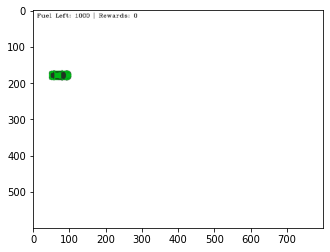

In [60]:
env = CarScape()
obs = env.reset()
plt.imshow(obs)

In [109]:

env = CarScape()
obs = env.reset()
episodes = 5
for episode in range(1,episodes+1):
    state=env.reset()
    done=False
    score=0
    
    while not done:
        env.render()
        action=env.action_space.sample()
        n_state,reward,done,info=env.step(action)
        score +=reward
    print("episode:{} Score:{}".format(episode,score))
env.close()

error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\core\src\alloc.cpp:73: error: (-4:Insufficient memory) Failed to allocate 12000000 bytes in function 'cv::OutOfMemoryError'


## Training agent with a model

In [87]:
#path to save trained models
log_path=os.path.join("training","logs")

In [101]:
env=DummyVecEnv([lambda:env])
model=PPO("MlpPolicy",env,verbose=1,tensorboard_log=log_path)

Using cpu device


MemoryError: Unable to allocate 8.01 GiB for an array with shape (2048, 1, 500, 700, 3) and data type float32